In [125]:
import pandas as pd
import numpy as np
import pickle

from matplotlib import pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder

%matplotlib inline 

pd.options.mode.chained_assignment = None 

np.random.seed(42)

import warnings
warnings.filterwarnings("ignore")

In [41]:
sns.set(rc={
    'figure.figsize': (12, 8),
    'font.size': 14
})

# Set palette
sns.set_palette("husl")

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 5000)

In [75]:
data = pd.read_csv('ml_imdb_data.csv')
data.drop(columns = data.columns[0],inplace=True)

In [76]:
certificates = data['Certificate'].unique()
certificates = certificates.tolist()
tmp_num = [x for x in range(18)]
data['Certificate'] = data['Certificate'].apply(lambda x: int(tmp_num[certificates.index(x)]))

In [78]:
metascore_mean = data['Metascore'].mean()
data['Metascore'].fillna(value = metascore_mean, inplace= True)
gross_mean = data['Gross'].mean()
data['Gross'].fillna(value= gross_mean, inplace= True)

In [79]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17483 entries, 0 to 17482
Data columns (total 29 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Title           17483 non-null  int64  
 1   Year            17483 non-null  int64  
 2   Certificate     17483 non-null  int64  
 3   Rating          17483 non-null  float64
 4   Metascore       17483 non-null  float64
 5   Votes           17483 non-null  int64  
 6   Gross           17483 non-null  float64
 7   Movie_time_min  17483 non-null  int64  
 8   History         17483 non-null  int64  
 9   Biography       17483 non-null  int64  
 10  Horror          17483 non-null  int64  
 11  Adventure       17483 non-null  int64  
 12  Animation       17483 non-null  int64  
 13  Sport           17483 non-null  int64  
 14  Thriller        17483 non-null  int64  
 15  Drama           17483 non-null  int64  
 16  Western         17483 non-null  int64  
 17  Action          17483 non-null 

In [46]:
data.head()

,Title,Year,Certificate,Rating,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime
0,15,2008,0,9.0,84.000000,2428474,5.348584e+08,152,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
1,45,2003,0,8.9,94.000000,1715249,3.778459e+08,201,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
2,9,2010,0,8.8,74.000000,2179206,2.925762e+08,148,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
3,49,2001,0,8.8,92.000000,1736538,3.155448e+08,178,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
4,15,2016,1,8.7,73.967558,106888,5.749955e+07,135,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0


In [14]:
def regplot(variable):
    plt.figure(figsize=(9,3))
    sns.regplot(x=variable, y='Rating', data= data,color='b')
    plt.title(variable + ' vs. Rating')
    plt.xlabel(variable)
    plt.ylabel('Rating')
    plt.show()

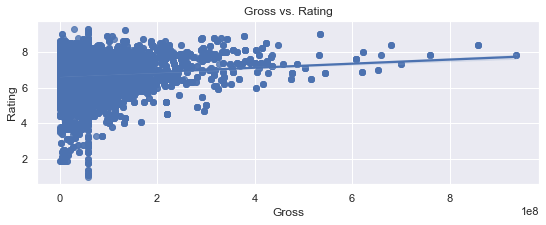

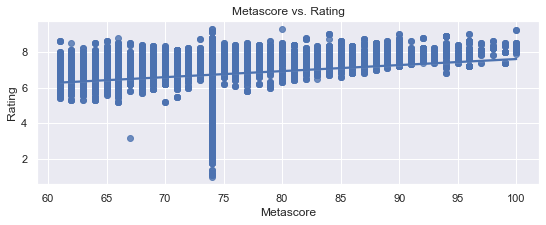

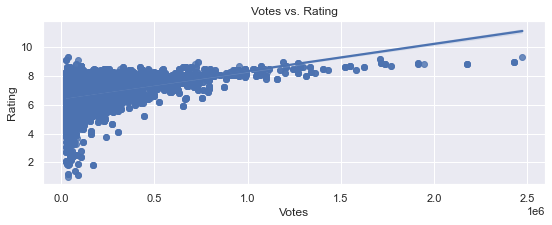

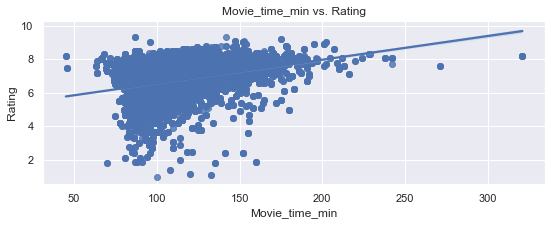

In [15]:
regplot_list = ['Gross', 'Metascore', 'Votes', 'Movie_time_min']
for i in regplot_list:
    regplot(i)

In [84]:
df = data
cat = [0 for i in range(df.shape[0])]

In [85]:
for i in range(len(cat)):
    if df.iloc[i,3] >= 9.5:
        cat[i] = 0
    if 8.5 <= df.iloc[i,3] < 9.5:
        cat[i] = 1
    if 7 <= df.iloc[i,3] < 8.5:
        cat[i] = 2
    if 5 <= df.iloc[i,3] < 7:
        cat[i] = 3
    if df.iloc[i,3] < 5:
        cat[i] = 4

In [87]:
df['target'] = cat

In [88]:
df.head()

,Title,Year,Certificate,Rating,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime,target
0,15,2008,0,9.0,84.000000,2428474,5.348584e+08,152,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,45,2003,0,8.9,94.000000,1715249,3.778459e+08,201,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,9,2010,0,8.8,74.000000,2179206,2.925762e+08,148,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,49,2001,0,8.8,92.000000,1736538,3.155448e+08,178,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,15,2016,1,8.7,73.967558,106888,5.749955e+07,135,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [89]:
del df['Rating']

In [90]:
df.head()

,Title,Year,Certificate,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime,target
0,15,2008,0,84.000000,2428474,5.348584e+08,152,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,45,2003,0,94.000000,1715249,3.778459e+08,201,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,9,2010,0,74.000000,2179206,2.925762e+08,148,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,49,2001,0,92.000000,1736538,3.155448e+08,178,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,15,2016,1,73.967558,106888,5.749955e+07,135,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [91]:
df.columns[df.isnull().any()]

Index([], dtype='object')

In [92]:
df.isnull().sum()

Title             0
Year              0
Certificate       0
Metascore         0
Votes             0
Gross             0
Movie_time_min    0
History           0
Biography         0
Horror            0
Adventure         0
Animation         0
Sport             0
Thriller          0
Drama             0
Western           0
Action            0
Mystery           0
Music             0
Romance           0
Film-Noir         0
War               0
Comedy            0
Family            0
Musical           0
Sci-Fi            0
Fantasy           0
Crime             0
target            0
dtype: int64

In [93]:
df.head()

,Title,Year,Certificate,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime,target
0,15,2008,0,84.000000,2428474,5.348584e+08,152,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1
1,45,2003,0,94.000000,1715249,3.778459e+08,201,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
2,9,2010,0,74.000000,2179206,2.925762e+08,148,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1
3,49,2001,0,92.000000,1736538,3.155448e+08,178,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,15,2016,1,73.967558,106888,5.749955e+07,135,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,1


In [108]:
max_v = df.max(axis=0)[:7]
min_v = df.min(axis=0)[:7]
miu = df.sum(axis=0)/df.shape[0]
for i in max_v.index:
    df[i] = (df[i] - miu[i])/(max_v[i]-min_v[i])

In [111]:
df.head(1)

,Title,Year,Certificate,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime,target
0,0.000303,0.052713,-0.128239,0.257242,0.935991,0.509638,0.148315,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,1


In [112]:
X = data.drop(['target'], axis = 1)
y = data.target

In [116]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print("Length of training sets:",len(X_train), len(X_test))
print("Length of testing sets:",len(y_train), len(y_test))

Length of training sets: 11713 5770
Length of testing sets: 11713 5770


In [117]:
X_train

,Title,Year,Certificate,Metascore,Votes,Gross,Movie_time_min,History,Biography,Horror,Adventure,Animation,Sport,Thriller,Drama,Western,Action,Mystery,Music,Romance,Film-Noir,War,Comedy,Family,Musical,Sci-Fi,Fantasy,Crime
2910,-0.146038,0.082416,0.342349,-2.812194e-01,0.032743,0.091944,-0.054583,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
12403,0.244206,0.023010,-0.128239,1.803190e-01,0.179802,0.248236,0.166431,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
5734,-0.109453,0.181425,-0.010592,-2.555784e-01,0.011729,0.000000,-0.069076,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1
7458,0.097864,-0.135406,-0.010592,5.211391e-02,0.028775,0.037713,-0.058207,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0
5712,-0.048477,0.032911,0.107055,2.059601e-01,-0.033841,-0.054793,0.072228,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,0.061279,-0.422535,0.107055,4.110883e-01,-0.043328,-0.061331,-0.076323,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
11964,-0.097258,-0.184911,-0.010592,3.598062e-01,0.101026,-0.005900,0.177301,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
5390,-0.060672,0.032911,-0.128239,3.643809e-16,-0.033839,0.001223,-0.047337,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
860,0.000303,0.161623,-0.010592,-3.325015e-01,-0.007379,0.000000,0.050489,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1


In [118]:
y_train

2910     3
12403    2
5734     2
7458     2
5712     2
        ..
11284    2
11964    2
5390     4
860      3
15795    2
Name: target, Length: 11713, dtype: int64

In [120]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train, y_train)
acc_log_train = round(logreg.score(X_train, y_train)*100,2) 
acc_log_test = round(logreg.score(X_test,y_test)*100,2)
print("Training Accuracy: % {}".format(acc_log_train))
print("Testing Accuracy: % {}".format(acc_log_test))

Training Accuracy: % 74.78
Testing Accuracy: % 74.02


In [122]:
random_state = 17
classifier = [DecisionTreeClassifier(random_state = random_state),
             SVC(random_state = random_state),
             RandomForestClassifier(random_state = random_state),
             LogisticRegression(random_state = random_state),
             KNeighborsClassifier()]

dt_param_grid = {"min_samples_split" : range(10,500,20),
                "max_depth": range(1,20,2)}

svc_param_grid = {"kernel" : ["rbf"],
                 "gamma": [0.001, 0.01, 0.1, 1],
                 "C": [1,10,50,100,200,300,1000],
                  "probability":[False]}

rf_param_grid = {"max_features": [1,3,10],
                "min_samples_split":[2,3,10],
                "min_samples_leaf":[1,3,10],
                "bootstrap":[False],
                "n_estimators":[100,300],
                "criterion":["gini"]}

logreg_param_grid = {"C":np.logspace(-3,3,7),
                    "penalty": ["l1","l2"],
                     "solver" : ["liblinear"]
                    }

knn_param_grid = {"n_neighbors": np.linspace(1,19,10, dtype = int).tolist(),
                 "weights": ["uniform","distance"],
                 "metric":["euclidean","manhattan"]}
classifier_param = [dt_param_grid,
                   svc_param_grid,
                   rf_param_grid,
                   logreg_param_grid,
                   knn_param_grid]

In [126]:
cv_result = []
best_estimators = []
for i in range(len(classifier)):
    clf = GridSearchCV(classifier[i], param_grid=classifier_param[i], cv = StratifiedKFold(n_splits = 10), scoring = "accuracy", n_jobs = -1,verbose = 1)
    clf.fit(X_train,y_train)
    cv_result.append(clf.best_score_)
    best_estimators.append(clf.best_estimator_)
    print(cv_result[i])

Fitting 10 folds for each of 250 candidates, totalling 2500 fits
0.8993439287910627
Fitting 10 folds for each of 28 candidates, totalling 280 fits
0.9063427746187005
Fitting 10 folds for each of 54 candidates, totalling 540 fits
0.9714852391264431
Fitting 10 folds for each of 14 candidates, totalling 140 fits
0.7516425825480978
Fitting 10 folds for each of 40 candidates, totalling 400 fits
0.9555199167596902


In [127]:
best_estimators

[DecisionTreeClassifier(max_depth=19, min_samples_split=10, random_state=17),
 SVC(C=1000, gamma=1, random_state=17),
 RandomForestClassifier(bootstrap=False, max_features=3, random_state=17),
 LogisticRegression(C=10.0, penalty='l1', random_state=17, solver='liblinear'),
 KNeighborsClassifier(metric='manhattan', n_neighbors=19, weights='distance')]

In [129]:
cv_result = [100*i for i in cv_result]
cv_result

[89.93439287910627,
 90.63427746187006,
 97.14852391264431,
 75.16425825480978,
 95.55199167596902]

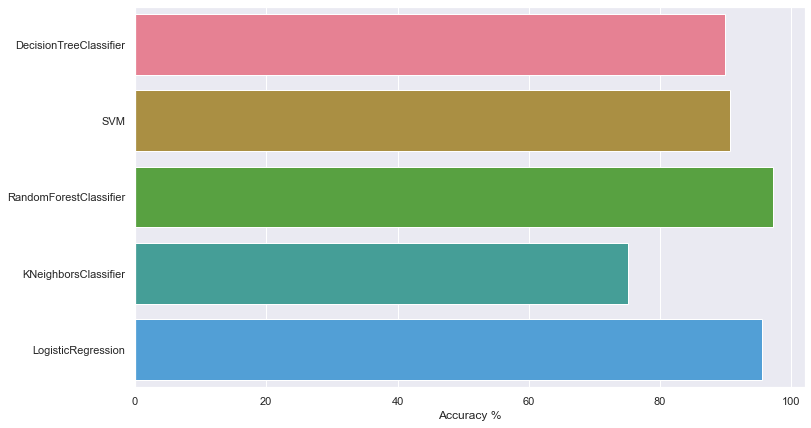

DecisionTreeClassifier Accuracy: 89.93439287910627 %
SVM Accuracy: 90.63427746187006 %
RandomForestClassifier Accuracy: 97.14852391264431 %
KNeighborsClassifier Accuracy: 75.16425825480978 %
LogisticRegression Accuracy: 95.55199167596902 %


In [130]:
results=pd.DataFrame({"Cross Validation Best Scores": cv_result, "ML Models": ["DecisionTreeClassifier", "SVM", "RandomForestClassifier", "KNeighborsClassifier", "LogisticRegression"]})
f,ax=plt.subplots(figsize=(12,7))
g = sns.barplot(data=results, y="ML Models", x="Cross Validation Best Scores")
g.set_ylabel("")
g.set_xlabel("Accuracy %")
plt.show()
for i in range(len(results)):
    print(results["ML Models"][i], "Accuracy:", results["Cross Validation Best Scores"][i], "%")

In [132]:
votingC = VotingClassifier(estimators = [("dt",best_estimators[0]),
                                        ("rfc",best_estimators[2]),
                                        ("knn",best_estimators[3])],
                                        voting = "soft", n_jobs = -1)
votingC = votingC.fit(X_train, y_train)
print(accuracy_score(votingC.predict(X_test),y_test))

0.9542461005199306
